# Regime Detection via Unsupervised Learning
This notebook performs market regime detection using unsupervised learning based on order book (depth20) and trade volume (aggTrade) data.

In [59]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# Step 2: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap
import hdbscan
import os
import glob

## Step 3: Load and Preprocess Data

In [61]:
# Set folder paths
depth_path = '/content/drive/MyDrive/RegimeDetection/depth20_1000ms'
trade_path = '/content/drive/MyDrive/RegimeDetection/aggTrade'

# Load and concatenate all trade files (with Time column)
trade_files = sorted(glob.glob(trade_path + '/*.txt'))
aggTrade_df = pd.concat([
    pd.read_csv(f, skiprows=1, names=['Time', 'Price', 'Quantity', 'IsMarketMaker', 'NumTrades', 'M'], low_memory=False)
    for f in trade_files
])

# Parse and clean Time column
aggTrade_df['Time'] = aggTrade_df['Time'].astype(str).str.split('+').str[0].str.strip()
aggTrade_df['Time'] = pd.to_datetime(aggTrade_df['Time'], format='%Y-%m-%d %H:%M:%S.%f')

aggTrade_df['Time'] = aggTrade_df['Time'].astype(str)
aggTrade_df['Time'] = aggTrade_df['Time'].str.split('+').str[0].str.strip()
aggTrade_df['Time'] = pd.to_datetime(aggTrade_df['Time'], format='%Y-%m-%d %H:%M:%S.%f')


In [62]:
# Load and concatenate all depth files
depth_files = sorted(glob.glob(depth_path + '/*.txt'))
depth_df = pd.concat([pd.read_csv(f) for f in depth_files])
depth_df.rename(columns={depth_df.columns[0]: 'Time'}, inplace=True)
depth_df['Time'] = pd.to_datetime(depth_df['Time'].str.split('+').str[0].str.strip())

## Step 4: Feature Engineering

In [63]:
# Set time index
print("aggTrade_df columns:", aggTrade_df.columns)
print("depth_df columns:", depth_df.columns)

aggTrade_df.set_index('Time', inplace=True)
depth_df.set_index('Time', inplace=True)

# Resample
depth_df_resampled = depth_df.resample('1S').ffill()
agg_resampled = aggTrade_df.resample('1S').agg({'Price': 'mean', 'Quantity': 'sum'}).dropna()

# Align time ranges
common_start = max(depth_df_resampled.index.min(), agg_resampled.index.min())
common_end = min(depth_df_resampled.index.max(), agg_resampled.index.max())

depth_df_resampled = depth_df_resampled.loc[common_start:common_end]
agg_resampled = agg_resampled.loc[common_start:common_end]

# Merge
data = depth_df_resampled.join(agg_resampled, how='inner')

print("After merge - data shape:", data.shape)


aggTrade_df columns: Index(['Time', 'Price', 'Quantity', 'IsMarketMaker', 'NumTrades', 'M'], dtype='object')
depth_df columns: Index(['Time', 'BidPriceL20', 'BidQtyL20', 'BidPriceL19', 'BidQtyL19',
       'BidPriceL18', 'BidQtyL18', 'BidPriceL17', 'BidQtyL17', 'BidPriceL16',
       'BidQtyL16', 'BidPriceL15', 'BidQtyL15', 'BidPriceL14', 'BidQtyL14',
       'BidPriceL13', 'BidQtyL13', 'BidPriceL12', 'BidQtyL12', 'BidPriceL11',
       'BidQtyL11', 'BidPriceL10', 'BidQtyL10', 'BidPriceL9', 'BidQtyL9',
       'BidPriceL8', 'BidQtyL8', 'BidPriceL7', 'BidQtyL7', 'BidPriceL6',
       'BidQtyL6', 'BidPriceL5', 'BidQtyL5', 'BidPriceL4', 'BidQtyL4',
       'BidPriceL3', 'BidQtyL3', 'BidPriceL2', 'BidQtyL2', 'BidPriceL1',
       'BidQtyL1', 'AskPriceL1', 'AskQtyL1', 'AskPriceL2', 'AskQtyL2',
       'AskPriceL3', 'AskQtyL3', 'AskPriceL4', 'AskQtyL4', 'AskPriceL5',
       'AskQtyL5', 'AskPriceL6', 'AskQtyL6', 'AskPriceL7', 'AskQtyL7',
       'AskPriceL8', 'AskQtyL8', 'AskPriceL9', 'AskQtyL9', 'AskP

<ipython-input-63-17dc6b7cee1a>:9: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  depth_df_resampled = depth_df.resample('1S').ffill()
<ipython-input-63-17dc6b7cee1a>:10: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  agg_resampled = aggTrade_df.resample('1S').agg({'Price': 'mean', 'Quantity': 'sum'}).dropna()


After merge - data shape: (155644, 82)


In [64]:
# Feature engineering
data['spread'] = data['AskPriceL1'] - data['BidPriceL1']
data['imbalance_lvl1'] = (data['BidQtyL1'] - data['AskQtyL1']) / (data['BidQtyL1'] + data['AskQtyL1'])
data['microprice'] = (data['BidPriceL1'] * data['AskQtyL1'] + data['AskPriceL1'] * data['BidQtyL1']) / (data['BidQtyL1'] + data['AskQtyL1'])
data['midprice'] = (data['BidPriceL1'] + data['AskPriceL1']) / 2
data['log_return'] = np.log(data['midprice'] / data['midprice'].shift(1))
data['volatility_10'] = data['log_return'].rolling(window=10).std()
data['cum_bid_qty'] = data[[col for col in data.columns if 'BidQty' in col]].sum(axis=1)
data['cum_ask_qty'] = data[[col for col in data.columns if 'AskQty' in col]].sum(axis=1)
# Print size before dropping to debug
print("Before dropna:", data.shape)

# Only drop rows where critical engineered features are missing
columns_to_check = ['spread', 'imbalance_lvl1', 'microprice', 'log_return', 'volatility_10']
min_required_cols = ['spread', 'imbalance_lvl1', 'microprice']
data = data.dropna(subset=min_required_cols)
data['log_return'] = data['log_return'].fillna(0)
data['volatility_10'] = data['volatility_10'].fillna(method='bfill').fillna(0)


print("After dropna:", data.shape)


Before dropna: (155644, 90)
After dropna: (155643, 90)


<ipython-input-64-ed5288ea1d2c>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['log_return'] = data['log_return'].fillna(0)
<ipython-input-64-ed5288ea1d2c>:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['volatility_10'] = data['volatility_10'].fillna(method='bfill').fillna(0)
<ipython-input-64-ed5288ea1d2c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['volatility_10'] = data['volatility_10'].fi

## Step 5: Normalization and Clustering

In [65]:

print("Final data shape:", data.shape)
print("Columns present:", data.columns.tolist())

# Select features
features = data[['spread', 'imbalance_lvl1', 'microprice', 'log_return', 'volatility_10', 'cum_bid_qty', 'cum_ask_qty', 'Quantity']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=0).fit(X_scaled)
data['regime'] = kmeans.labels_

Final data shape: (155643, 90)
Columns present: ['BidPriceL20', 'BidQtyL20', 'BidPriceL19', 'BidQtyL19', 'BidPriceL18', 'BidQtyL18', 'BidPriceL17', 'BidQtyL17', 'BidPriceL16', 'BidQtyL16', 'BidPriceL15', 'BidQtyL15', 'BidPriceL14', 'BidQtyL14', 'BidPriceL13', 'BidQtyL13', 'BidPriceL12', 'BidQtyL12', 'BidPriceL11', 'BidQtyL11', 'BidPriceL10', 'BidQtyL10', 'BidPriceL9', 'BidQtyL9', 'BidPriceL8', 'BidQtyL8', 'BidPriceL7', 'BidQtyL7', 'BidPriceL6', 'BidQtyL6', 'BidPriceL5', 'BidQtyL5', 'BidPriceL4', 'BidQtyL4', 'BidPriceL3', 'BidQtyL3', 'BidPriceL2', 'BidQtyL2', 'BidPriceL1', 'BidQtyL1', 'AskPriceL1', 'AskQtyL1', 'AskPriceL2', 'AskQtyL2', 'AskPriceL3', 'AskQtyL3', 'AskPriceL4', 'AskQtyL4', 'AskPriceL5', 'AskQtyL5', 'AskPriceL6', 'AskQtyL6', 'AskPriceL7', 'AskQtyL7', 'AskPriceL8', 'AskQtyL8', 'AskPriceL9', 'AskQtyL9', 'AskPriceL10', 'AskQtyL10', 'AskPriceL11', 'AskQtyL11', 'AskPriceL12', 'AskQtyL12', 'AskPriceL13', 'AskQtyL13', 'AskPriceL14', 'AskQtyL14', 'AskPriceL15', 'AskQtyL15', 'AskPri

## Step 6: Visualization and Analysis

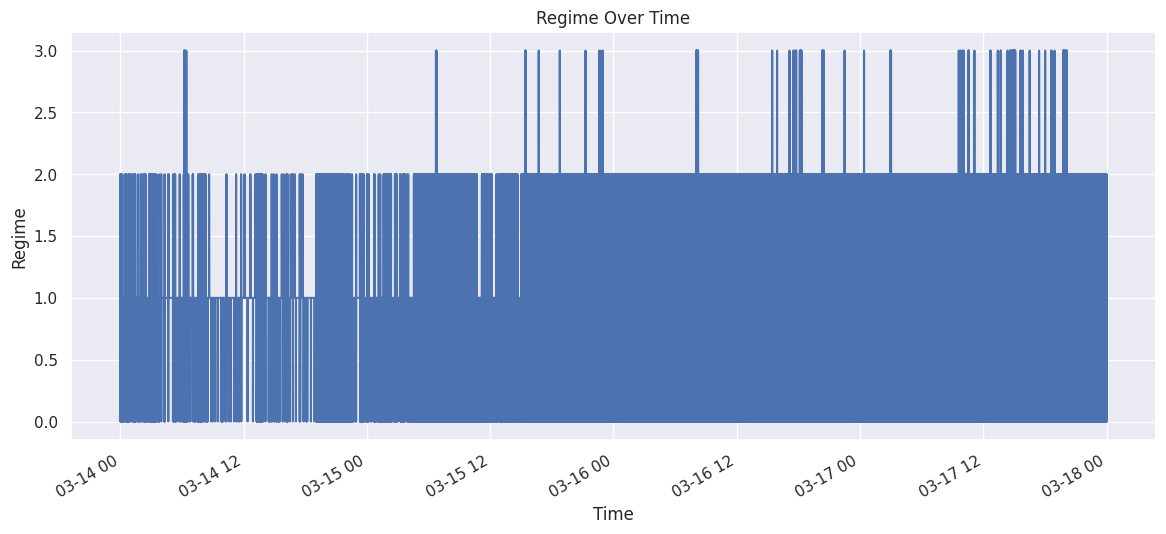

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


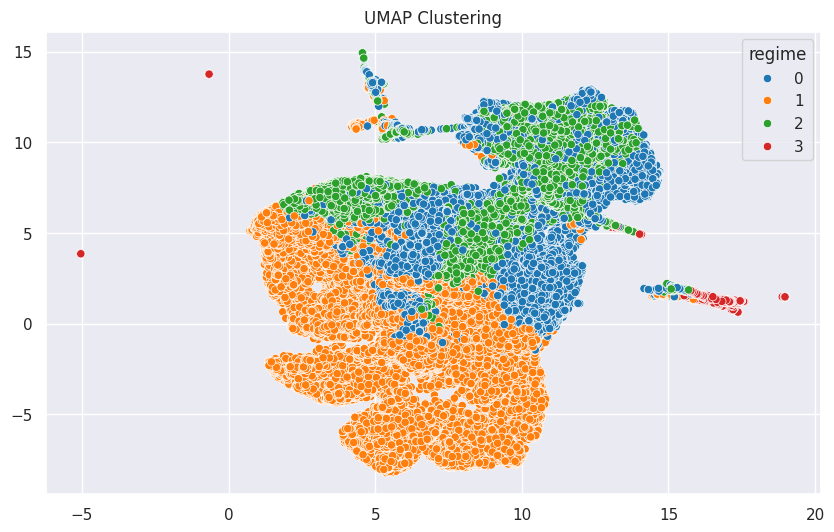

In [66]:
sns.set(style='darkgrid')
plt.figure(figsize=(14, 6))
data['regime'].plot(title='Regime Over Time')
plt.xlabel('Time')
plt.ylabel('Regime')
plt.show()

# UMAP Visualization
X_umap = umap.UMAP().fit_transform(X_scaled)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=data['regime'], palette='tab10')
plt.title('UMAP Clustering')
plt.show()